About this Dataset: Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

Goal:

1) Understanding what content is available in different countries
2) Identifying similar content by matching text-based features
3) Network analysis of Actors / Directors and find interesting insights
4) Does Netflix has more focus on TV Shows than movies in recent years.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


In [ ]:
#!pip install python-louvain

In [3]:
os.getcwd()
os.chdir("F:/Data analysis/Netflix analysis")
file_path ="netflix_titles.csv"
df = pd.read_csv(file_path)


print("Loaded dataset shape:", df.shape)

# Clean column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Columns:", df.columns.tolist())


#Split and convert to list
def split_and_strip(x):
    if pd.isna(x): 
        return []
    return [p.strip() for p in re.split(r',|;|\|', str(x)) if p.strip()]

Loaded dataset shape: (8807, 12)
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [4]:
# Countries with the most content

df['countries_list'] = df['country'].apply(split_and_strip)

#Convert separate rows for each country in the list
df_country = df.explode('countries_list').rename(columns={'countries_list':'country_clean'})

# Count content per country
country_counts = (
    df_country.groupby('country_clean')
    .size()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)
print("\nTop 10 Countries by Content Count:\n", country_counts.head(10))



Top 10 Countries by Content Count:
       country_clean  Count
115   United States   3690
45            India   1046
114  United Kingdom    806
20           Canada    445
36           France    393
53            Japan    318
102           Spain    232
100     South Korea    231
38          Germany    226
67           Mexico    169


In [141]:
#Different contents in each country
df_country['content_list']=df_country.listed_in.apply(split_and_strip)
df_content=df_country.explode('content_list').rename(columns={'content_list':'content_clean'})
countries_content_dict=df_content.groupby('country_clean')['content_clean'].apply(set).to_dict()
print(countries_content_dict)

{'Afghanistan': {'Documentaries', 'International Movies'}, 'Albania': {'International Movies', 'Dramas'}, 'Algeria': {'Classic Movies', 'International Movies', 'Independent Movies', 'Dramas'}, 'Angola': {'Action & Adventure', 'International Movies'}, 'Argentina': {'TV Comedies', 'Documentaries', 'TV Dramas', 'Sci-Fi & Fantasy', 'Comedies', 'Teen TV Shows', 'LGBTQ Movies', 'Docuseries', 'International Movies', 'Classic Movies', 'Music & Musicals', 'Horror Movies', 'Crime TV Shows', 'Cult Movies', 'Action & Adventure', 'Romantic Movies', 'TV Horror', 'Spanish-Language TV Shows', 'Stand-Up Comedy', 'Children & Family Movies', 'Sports Movies', 'Dramas', 'International TV Shows', "Kids' TV", 'Reality TV', 'Movies', 'Romantic TV Shows', 'Thrillers', 'Classic & Cult TV', 'Independent Movies'}, 'Armenia': {'Documentaries', 'International Movies'}, 'Australia': {'TV Mysteries', 'TV Comedies', 'Documentaries', 'TV Dramas', 'Sci-Fi & Fantasy', 'Comedies', 'TV Thrillers', 'Teen TV Shows', 'LGBTQ M

In [6]:
# Finding movies/series with similar content based on the description

text_fields = ['description','listed_in']
df["combined_text"]=df[text_fields[0]] + " " + df[text_fields[1]]

vectorizer = TfidfVectorizer(max_features=20000,stop_words="english")
tf_idf = vectorizer.fit_transform(df.combined_text)     # A matrix whose row corresponds to a document and columns correspond to a word. Each case is the tf idf score of that word in the document

cosine_sim=cosine_similarity(tf_idf,tf_idf)

Similar_content=[]
for i, row in enumerate(cosine_sim):
    contents=[]
    similar_idx=row.argsort()[-6:-1] # second highest (since highest = itself)
    similar_idx=list(reversed(similar_idx))
    for j in similar_idx:
        contents.append(df['title'][j])
    Similar_content.append(contents)

df_sim = pd.DataFrame(df.title)
df_sim['Similar_content']=Similar_content
print(df_sim)
    

                      title                                    Similar_content
0      Dick Johnson Is Dead  [End Game, The Soul, The Death and Life of Mar...
1             Blood & Water  [Dive Club, Lion Pride, More to Say, Clickbait...
2                 Ganglands  [The Eagle of El-Se'eed, Narcos, The Good Band...
3     Jailbirds New Orleans  [Jailbirds, Border Patrol, Rica, Famosa, Latin...
4              Kota Factory  [Cheese in the Trap, Single Ladies Senior, Rac...
...                     ...                                                ...
8802                 Zodiac  [Victim of Beauty, Krishna Cottage, No One Kil...
8803            Zombie Dumb  [Diablero, Reply 1988, Kiss Me First, Bring It...
8804             Zombieland  [True to the Game, The Last Kids on Earth, The...
8805                   Zoom  [Menahi, Free Rein: The Twelve Neighs of Chris...
8806                 Zubaan  [A Very Country Christmas, Been So Long, Rock ...

[8807 rows x 2 columns]


In [7]:
# Creating a network of actors and directors and studying trends

print(df_country.country.value_counts()[:5])
df_states=df_country.loc[df_country.country=="United States"]

#highest in US
#We study the trends in US film industry



country
United States     2818
India              972
United Kingdom     419
Japan              245
South Korea        199
Name: count, dtype: int64


In [8]:
#Network of actors. Each node represents an actor. Edge if acted together and weight represents the number of movies worked together.
G=nx.Graph()
df_states['actor_list']=df_states.cast.apply(split_and_strip)

for actors in df_states.actor_list:
    if(len(actors)<=1):
        continue
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            a,b=actors[i],actors[j]
            if(G.has_edge(a,b)):
                G[a][b]['weight']+=1
            else:
                G.add_edge(a,b,weight=1)

print(G.number_of_edges())

C:\Users\sanja\AppData\Local\Temp\ipykernel_23264\2478714328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_states['actor_list']=df_states.cast.apply(split_and_strip)


96923


In [9]:
# Grouping the actors in clusters based on their history of work.

import community as community_louvain


G2=G.copy()
G2.remove_nodes_from([n for n in G2.nodes() if G2.degree(n,weight="weight") <= 10])


partition = community_louvain.best_partition(G2, weight="weight",resolution=2)

clusters = defaultdict(list)
for node, comm in partition.items():
    clusters[comm].append(node)
    
num_clusters=max(partition.values())

for comm, members in clusters.items():
    print(f"Cluster {comm}: {members}")

    

Cluster 0: ['Melissa McCarthy', 'Jean Smart', 'Iggy Pop', 'Chevy Chase', 'Eric Bana', 'Juno Temple', 'Julia Garner', 'Keiko Agena', 'Jeff Perry', 'Kevin Zegers', 'Jake Abel', 'Ewan McGregor', 'Bill Pullman', 'Rebecca Dayan', 'David Pittu', 'Krysta Rodriguez', 'Rory Culkin', 'Vera Farmiga', 'Gian Franco Rodriguez', 'Sullivan Jones', 'Kelly Bishop', 'Dilone', 'James Waterston', 'Jason Kravits', 'Mary Beth Peil', 'Lauren Graham', 'Alexis Bledel', 'Scott Patterson', 'Yanic Truesdale', 'Edward Herrmann', 'Sean Gunn', 'Liza Weil', 'Liz Torres', 'Jared Padalecki', 'Michael Emerson', 'Nicholas Braun', 'Jim Caviezel', 'Matt Czuchry', 'Milo Ventimiglia', 'Rose Abdoo', 'Dayo Okeniyi', 'Kevin Chapman']
Cluster 1: ["Chris O'Dowd", 'Richard Jenkins', 'John Malkovich', 'Fred Willard', 'Christopher Guest', 'James Gandolfini', 'Slaine', 'Max Casella', 'Mindy Kaling', 'Billy Magnussen', 'Lucy Punch', 'Sarah Baker', 'Jim Carrey', 'Téa Leoni', 'John Michael Higgins', 'Richard Burgi', 'Carlos Jacott', 'Par

In [10]:
#Network of directors and actors. A directed edge from a director to an actor, whose weight is the number of films worked together.
P=nx.DiGraph()
df2=df_states[["director","actor_list"]].dropna()
for _,x in df2.iterrows():
    dire=x['director']
    for y in x['actor_list']:
        act=y
        if(P.has_edge(dire,act)):
            P[dire][act]["weight"]+=1
        else:
            P.add_edge(dire,act,weight=1)

print(P.number_of_edges())

14162


In [11]:
#Finds the directors with maximum connections or influence within actors.
deg=nx.degree_centrality(P)
max_node = max(deg, key=deg.get)
max_value = deg[max_node]
top5 = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:5]
top5

[('Martin Scorsese', 0.00782608695652174),
 ('Quentin Tarantino', 0.005314009661835748),
 ('Steven Spielberg', 0.005217391304347826),
 ('Clint Eastwood', 0.005217391304347826),
 ('Steve Brill', 0.005120772946859903)]

In [133]:
#Betweenness centrality explains how important the node is in this network, which acts as a bridge in the network
bet=nx.betweenness_centrality(P)
max_node = max(bet, key=bet.get)
max_value = bet[max_node]
top5 = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5]
top5

[('Natasha Lyonne', 2.329334253863824e-06),
 ('James Franco', 1.8111857525033342e-06),
 ('Jeff Garlin', 1.8111857525033342e-06),
 ('Jon Favreau', 1.3910653459948288e-06),
 ('Martin Lawrence', 1.2416892014584714e-06)]

In [134]:
#Fav actors of the network
in_deg = nx.in_degree_centrality(P)
top5 = sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:5]
top5

[('Samuel L. Jackson', 0.0014492753623188406),
 ('James Franco', 0.001256038647342995),
 ('Nicolas Cage', 0.001256038647342995),
 ('Laura Bailey', 0.001256038647342995),
 ('Dennis Quaid', 0.0011594202898550724)]

In [135]:
#Top 5 accessible actors
clos = nx.closeness_centrality(P)
top5 = sorted(clos.items(), key=lambda x: x[1], reverse=True)[:5]
top5

[('Samuel L. Jackson', 0.0015164881327452216),
 ('Seth Rogen', 0.0014645308924485126),
 ('Kristen Stewart', 0.0013753907360045468),
 ('Maria Bello', 0.0013545150501672243),
 ('Rosario Dawson', 0.0012806668561144263)]

In [136]:
#Top 5 directors who can access a wide network of actors
out_clos = nx.closeness_centrality(P.reverse())
top5 = sorted(out_clos.items(), key=lambda x: x[1], reverse=True)[:5]
top5

[('Martin Scorsese', 0.00782608695652174),
 ('Steve Brill', 0.006887645286267757),
 ('David Fincher', 0.005710928319623972),
 ('Robert Rodriguez', 0.005525422107428134),
 ('Quentin Tarantino', 0.0054761904761904765)]

In [12]:
#Trend in the past few years on TV shows and Movies
trend_df = (
    df.groupby(['release_year','type'])
    .size()
    .reset_index(name='count')
    .dropna(subset=['release_year'])
    .sort_values(['release_year','type'])
)
pivot = trend_df.pivot(index='release_year', columns='type', values='count').fillna(0)
pivot

type,Movie,TV Show
release_year,,
1925,0.0,1.0
1942,2.0,0.0
1943,3.0,0.0
1944,3.0,0.0
1945,3.0,1.0
...,...,...
2017,767.0,265.0
2018,767.0,380.0
2019,633.0,397.0


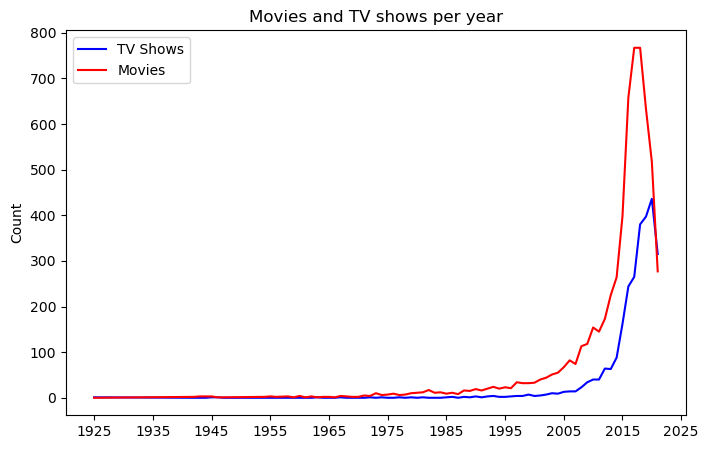

In [21]:
import matplotlib.pyplot
plt.figure(figsize=(8, 5))
plt.title("Movies and TV shows per year")
plt.ylabel("Count")
plt.xticks(range(min(pivot.index),max(pivot.index)+10,10))
plt.plot(pivot.index,pivot["TV Show"], color='blue', label='TV Shows')
plt.plot(pivot.index,pivot["Movie"], color='red', label='Movies')
plt.legend()


In [ ]:
#We can see a sharp reduction in the number of movies around 2018 against the trend followed.
#A similar decline is also shown for the TV shows.
#The influence of the pandemic is shown here.
#From the data, we cannot confirm statistically a decline of movies against TV shows.
